In [9]:
#torchinfo用于查看模型结构
import torch
import torch.nn as nn
# !pip install _____
from torchinfo import summary

In [13]:
#模型定义
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        #卷积层1:输入一个通道 输出六个通道 卷积核5*5
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        #卷积层2:输入6个通道 输出16个通道 卷积核5*5
        self.conv2=nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        #全连接层1:输入16*4*4个节点 输出120个节点
        self.fc1=nn.Linear(in_features=16*4*4, out_features=120)
        #全连接层2
        self.fc2=nn.Linear(in_features=120,out_features=84)
        #全连接层3
        self.fc3=nn.Linear(in_features=84,out_features=num_classes)

    def forward(self,x):
        #卷积层 池化
        x=torch.relu(self.conv1(x))
        x=nn.functional.max_pool2d(x,kernel_size=2) #最大池化
        x=torch.relu(self.conv2(x))
        x=nn.functional.max_pool2d(x,kernel_size=2)
        #全连接层
        #将多维张量展开为一维
        x=x.view(-1,16*4*4)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return x



In [17]:
#查看模型结构
summary(LeNet(),input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 24, 24]            156
├─Conv2d: 1-2                            [1, 16, 8, 8]             2,416
├─Linear: 1-3                            [1, 120]                  30,840
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.18
Estimated Total Size (MB): 0.22

In [29]:
#模型训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
#!pip install tqdm
from tqdm import * #用于显示进度条并评估任务时间开销
import numpy as np
import sys

In [43]:
torch.manual_seed(0)

model =LeNet() #模型
optimizer=optim.SGD(model.parameters(), lr=0.02) #优化器
criterion=nn.CrossEntropyLoss() #损失函数

#设置数据变换和数据加载器
#transform = transforms.Compose([
#    transforms.ToTensor(), #将数据转换为张量
#  ])

#加载数据    
train_dataset = datasets.MNIST(root='data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = datasets.MNIST(root='data',train=False,transform=transforms.ToTensor(),download=True)
#root是存放数据位置；transform代表数据处理方式使用Totensor表示直接转换为张量（高维数组）；doenload设置为True表示root里有数据就用没有就下载到root
#实例化数据加载器
train_loader=DataLoader(train_dataset, batch_size=256,shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=256,shuffle=False)

#设置epoch数并开始训练
num_epochs=10
loss_history=[]
acc_history=[]


#tqdm()用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss=0
    total_correct=0
    
    #训练
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()

    #评估
    model.eval()
    with torch.no_grad():
        for inputs,labels in test_loader:
            outputs=model(inputs)
            total_correct+=(outputs.argmax(1)==labels).sum().item() #这里注意加一个argmax
            
    #记录训练损失和测试acc
    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct/len(test_dataset))

    #打印中间值
    if epoch%2==0:
        tqdm.write(f'Epoch:{epoch} Loss:{loss_history[-1]} ACC:{acc_history[-1]}')






Epoch:0 Loss:2.732564497715498 ACC:0.2633                                                                              
Epoch:2 Loss:2.6300298093136343 ACC:0.691                                                                              
Epoch:4 Loss:1.9097356563455026 ACC:0.9047                                                                             
Epoch:6 Loss:1.7178314065790528 ACC:0.9424                                                                             
Epoch:8 Loss:1.5847731913848244 ACC:0.9417                                                                             
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.25s/it]


In [44]:
print(acc_history[-1])

0.9626


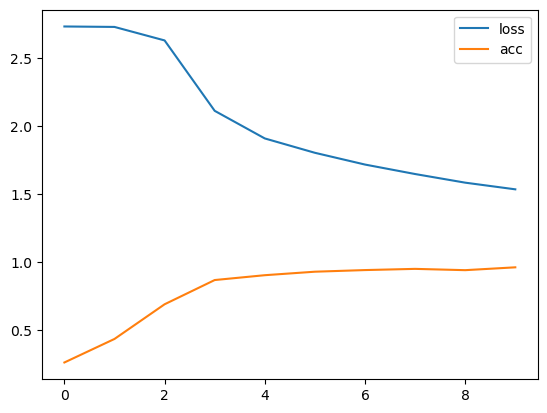

In [45]:
#绘制出损失和正确率图
import matplotlib.pyplot as plt
plt.plot(loss_history,label='loss')
plt.plot(acc_history,label='acc')
plt.legend()
plt.show()